In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import math
import numpy as np
import random
import collections
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

In [2]:
env = gym.make('CartPole-v0').unwrapped
env.reset()

array([ 0.04323087, -0.04556405,  0.03638268, -0.04686725])

In [3]:
EPISODES = 700
LR = 0.001
GAMMA = 0.999
eps = 0.99
EPS_MIN = 0.01
EPS_DECAY = 0.99
BATCH_SIZE = 256
NUM_ACTIONS = env.action_space.n
NUM_OBS = len(env.reset())
CAPACITY = 10000
STEPS = 0
TARGET_UPDATE = 10
EPISODE_DURATION = []
REWARDS = []
AVG_OVER_100 = []
MAX_LOSS = []
STACKED_STATES = 4
flag = 0
FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor

In [4]:
class Replaymemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.index = 0
        
    def push(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.index] = transition
        self.index = (self.index + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
        
    def __len__(self):
        return len(self.memory)

In [5]:
class Network(nn.Module):
    def __init__(self, h_in, w_in):
        super(Network, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = STACKED_STATES, out_channels = 16, kernel_size = 5, stride = 2)
        self.bn0 = nn.BatchNorm2d(16)
        self.conv1 = nn.Conv2d(16, 64, kernel_size = 5, stride = 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 32, kernel_size = 5, stride = 2)
        self.bn2 = nn.BatchNorm2d(32)
        
        def get_hw(n, kernel_size = 5, stride = 2):
            return ((n - kernel_size)//stride) + 1
        h_out, w_out = get_hw(get_hw(get_hw(h_in))), get_hw(get_hw(get_hw(w_in)))
        lin_input = 32 * h_out * w_out
        
        self.ln0 = nn.Linear(lin_input, NUM_ACTIONS)
        
    def forward(self, t):
        t = F.relu(self.bn0(self.conv0(t)))
        t = F.relu(self.bn1(self.conv1(t)))
        t = F.relu(self.bn2(self.conv2(t)))
        t = self.ln0(t.view(t.size(0), -1))
        return t

In [6]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

def get_screen():
    if flag == 0:
        env.reset()
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    channels, screen_height, screen_width = screen.shape
    screen_img = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)
    screen = screen[:, :, slice_range]
    # convert to tensor
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen)

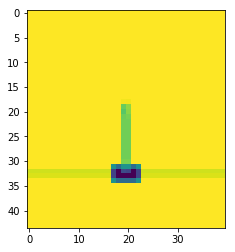

In [7]:
curr_screen = get_screen()
curr_screen = curr_screen[0] * 0.3 + curr_screen[1] * 0.59 + curr_screen[2] * 0.11
plt.imshow(curr_screen)
height, width = curr_screen.shape[0], curr_screen.shape[1]
curr_screen = curr_screen.reshape((1, 1, height, width))

In [8]:
curr_screen.shape

torch.Size([1, 1, 44, 40])

In [9]:
policy_net = Network(height, width)
target_net = Network(height, width)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr = LR)
memory = Replaymemory(CAPACITY)

In [10]:
def epsilon_greedy(state):
    prob = random.random()
    if prob < eps:
        action = torch.tensor(random.randrange(NUM_ACTIONS))
    else:
        with torch.no_grad():
            action = policy_net(state).argmax()
    return action.item()

In [11]:
def optimize():
    if len(memory) < BATCH_SIZE:
        print('not enough memory samples')
        return
    trans = memory.sample(BATCH_SIZE)
    state_batch, action_batch, next_state_batch, reward_batch = zip(*trans)

    is_non_terminating = torch.tensor(tuple(map(lambda q: q is not None, next_state_batch)), dtype = torch.bool)
    
    #non_final_next_states = torch.cat([i for i in next_state_batch if i is not None])
    l1 = []
    for i in range(BATCH_SIZE):
        if next_state_batch[i] is not None:
            l1.append(torch.cat(next_state_batch[i]))
    non_final_next_states = torch.cat(l1).reshape(is_non_terminating.sum().item(), STACKED_STATES, height, width)
    
    l2 = []
    for i in range(BATCH_SIZE):
        l2.append(torch.cat(state_batch[i]))
    state_batch = torch.cat(l2).reshape((BATCH_SIZE, STACKED_STATES, height, width))
    action_batch = torch.tensor(action_batch, dtype = torch.long)
    reward_batch = torch.tensor(reward_batch, dtype = torch.float)
    
    curr_q_vals = policy_net(state_batch).gather(1, action_batch.view(-1, 1))
                             
    max_q_vals = torch.zeros(BATCH_SIZE)
    
    max_q_vals[is_non_terminating] = target_net(non_final_next_states).max(1)[0].detach()
    
    next_q_vals = (reward_batch + GAMMA * max_q_vals).reshape(curr_q_vals.shape)
    
    loss = F.smooth_l1_loss(curr_q_vals, next_q_vals)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()    

In [12]:
net_reward = 0
avg_100 = 0
max_reward = 0
MAX_REWARD = []

for episode in range(EPISODES):
    time_in_episode = 0
    max_loss = 0
    curr_states = []
    flag = 0
    for i in range(STACKED_STATES):
        curr_screen = get_screen()
        curr_screen = curr_screen[0] * 0.3 + curr_screen[1] * 0.59 + curr_screen[2] * 0.11
        curr_states.append(curr_screen)
    flag = 1
    
    while True:
        env.render()
        time_in_episode += 1
        
        curr_action = epsilon_greedy(torch.cat(curr_states).reshape((1, STACKED_STATES, height, width)))
        obs, reward, done, info = env.step(curr_action)
        
        if eps > EPS_MIN:
            eps *= EPS_DECAY
        else:
            eps = 0.0
        
        if done:
            next_states = None
        else:
            next_states = []
            next_states = curr_states[1:]
            curr_screen = get_screen()
            curr_screen = curr_screen[0] * 0.3 + curr_screen[1] * 0.59 + curr_screen[2] * 0.11
            next_states.append(curr_screen)   
        
        memory.push((curr_states, curr_action, next_states, reward))
        
        loss = optimize()
        
        if loss is not None and loss > max_loss:
            max_loss = loss
            
        if reward > max_reward:
            max_reward = reward
            
        net_reward += reward
        avg_100 += reward
        
        curr_states = next_states
        
        if done:
            EPISODE_DURATION.append(time_in_episode)
            MAX_LOSS.append(max_loss)
            print(f'Maximum loss in episode {episode}: {max_loss}')
            print(f'Episode length: {time_in_episode}')
            print('\n')
            break
    
    if not episode % TARGET_UPDATE:
        target_net.load_state_dict(policy_net.state_dict())
        mean_reward = net_reward/TARGET_UPDATE
        print(f'Mean reward for last 10 episodes: {mean_reward}')
        REWARDS.append(mean_reward)
        net_reward = 0
    if not episode % 100:
        avg_over_100 = avg_100/100
        AVG_OVER_100.append(avg_over_100)
        MAX_REWARD.append(max_reward)
        print(f'Mean reward for last 100 episodes: {avg_over_100}')
        avg_100 = 0
        max_reward = 0
print('COMPLETE')
env.render()
env.close()

not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
Maximum loss in episode 0: 0
Episode length: 20


Mean reward for last 10 episodes: 2.0
Mean reward for last 100 episodes: 0.2
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memory samples
not enough memo

Maximum loss in episode 27: 0.002179787028580904
Episode length: 10


Maximum loss in episode 28: 0.0019884505309164524
Episode length: 10


Maximum loss in episode 29: 0.0020002354867756367
Episode length: 12


Maximum loss in episode 30: 0.0018827721942216158
Episode length: 9


Mean reward for last 10 episodes: 11.0
Maximum loss in episode 31: 0.4512608051300049
Episode length: 10


Maximum loss in episode 32: 0.024800047278404236
Episode length: 8


Maximum loss in episode 33: 0.020875196903944016
Episode length: 10


Maximum loss in episode 34: 0.018659410998225212
Episode length: 10


Maximum loss in episode 35: 0.013369022868573666
Episode length: 12


Maximum loss in episode 36: 0.010674778372049332
Episode length: 26


Maximum loss in episode 37: 0.00880137737840414
Episode length: 41


Maximum loss in episode 38: 0.00608002208173275
Episode length: 56


Maximum loss in episode 39: 0.005570883397012949
Episode length: 41


Maximum loss in episode 40: 0.00510718347504735
Episod

Maximum loss in episode 139: 0.28230559825897217
Episode length: 12


Maximum loss in episode 140: 0.23545314371585846
Episode length: 24


Mean reward for last 10 episodes: 72.4
Maximum loss in episode 141: 0.8014247417449951
Episode length: 51


Maximum loss in episode 142: 0.3596997559070587
Episode length: 80


Maximum loss in episode 143: 0.357647180557251
Episode length: 54


Maximum loss in episode 144: 0.3479198217391968
Episode length: 51


Maximum loss in episode 145: 0.3685157895088196
Episode length: 21


Maximum loss in episode 146: 0.29141533374786377
Episode length: 20


Maximum loss in episode 147: 0.39781755208969116
Episode length: 86


Maximum loss in episode 148: 0.3859483599662781
Episode length: 103


Maximum loss in episode 149: 0.2900705337524414
Episode length: 22


Maximum loss in episode 150: 0.3516145348548889
Episode length: 61


Mean reward for last 10 episodes: 54.9
Maximum loss in episode 151: 0.8397703170776367
Episode length: 90


Maximum loss in episo

Maximum loss in episode 251: 1.136496901512146
Episode length: 31


Maximum loss in episode 252: 0.7514647245407104
Episode length: 65


Maximum loss in episode 253: 0.7492088675498962
Episode length: 90


Maximum loss in episode 254: 0.6359991431236267
Episode length: 43


Maximum loss in episode 255: 0.7273629903793335
Episode length: 61


Maximum loss in episode 256: 0.7231508493423462
Episode length: 139


Maximum loss in episode 257: 0.6469671726226807
Episode length: 20


Maximum loss in episode 258: 0.6956202983856201
Episode length: 30


Maximum loss in episode 259: 0.6790415644645691
Episode length: 29


Maximum loss in episode 260: 0.5753571391105652
Episode length: 61


Mean reward for last 10 episodes: 56.9
Maximum loss in episode 261: 1.0313565731048584
Episode length: 93


Maximum loss in episode 262: 0.8686010837554932
Episode length: 97


Maximum loss in episode 263: 0.8205482959747314
Episode length: 102


Maximum loss in episode 264: 0.8162579536437988
Episode length:

Maximum loss in episode 363: 0.6620389223098755
Episode length: 73


Maximum loss in episode 364: 0.5971570611000061
Episode length: 17


Maximum loss in episode 365: 0.6803179383277893
Episode length: 77


Maximum loss in episode 366: 0.6980322003364563
Episode length: 50


Maximum loss in episode 367: 0.6042706370353699
Episode length: 31


Maximum loss in episode 368: 0.5736396908760071
Episode length: 11


Maximum loss in episode 369: 0.7552931904792786
Episode length: 45


Maximum loss in episode 370: 0.6890934109687805
Episode length: 23


Mean reward for last 10 episodes: 37.6
Maximum loss in episode 371: 1.1107865571975708
Episode length: 38


Maximum loss in episode 372: 0.7386893630027771
Episode length: 57


Maximum loss in episode 373: 0.886989176273346
Episode length: 100


Maximum loss in episode 374: 0.7151036858558655
Episode length: 22


Maximum loss in episode 375: 0.7583633065223694
Episode length: 37


Maximum loss in episode 376: 0.6549679040908813
Episode length: 

Maximum loss in episode 476: 1.3765681982040405
Episode length: 22


Maximum loss in episode 477: 1.5272300243377686
Episode length: 36


Maximum loss in episode 478: 1.3736767768859863
Episode length: 21


Maximum loss in episode 479: 1.5437469482421875
Episode length: 77


Maximum loss in episode 480: 1.5451586246490479
Episode length: 76


Mean reward for last 10 episodes: 51.5
Maximum loss in episode 481: 1.5352035760879517
Episode length: 10


Maximum loss in episode 482: 1.3224849700927734
Episode length: 13


Maximum loss in episode 483: 1.382520079612732
Episode length: 22


Maximum loss in episode 484: 1.494707465171814
Episode length: 105


Maximum loss in episode 485: 1.2166495323181152
Episode length: 19


Maximum loss in episode 486: 1.5092743635177612
Episode length: 45


Maximum loss in episode 487: 1.46200692653656
Episode length: 76


Maximum loss in episode 488: 1.3636752367019653
Episode length: 8


Maximum loss in episode 489: 1.109197974205017
Episode length: 31




Maximum loss in episode 589: 1.8602691888809204
Episode length: 73


Maximum loss in episode 590: 2.2749013900756836
Episode length: 20


Mean reward for last 10 episodes: 50.9
Maximum loss in episode 591: 2.0770695209503174
Episode length: 20


Maximum loss in episode 592: 2.1101419925689697
Episode length: 16


Maximum loss in episode 593: 1.9269969463348389
Episode length: 18


Maximum loss in episode 594: 1.6883212327957153
Episode length: 27


Maximum loss in episode 595: 2.195814371109009
Episode length: 38


Maximum loss in episode 596: 1.8352088928222656
Episode length: 22


Maximum loss in episode 597: 1.7336257696151733
Episode length: 38


Maximum loss in episode 598: 1.8284956216812134
Episode length: 12


Maximum loss in episode 599: 1.8692265748977661
Episode length: 16


Maximum loss in episode 600: 2.1135997772216797
Episode length: 41


Mean reward for last 10 episodes: 24.8
Mean reward for last 100 episodes: 49.33
Maximum loss in episode 601: 2.376082420349121
Episode

In [13]:
def plot_durations():
    plt.figure(figsize=(15,10))
    plt.xlabel('EPISODE')
    plt.ylabel('DURATION')
    plt.plot(EPISODE_DURATION)
    plt.grid()
    plt.show()

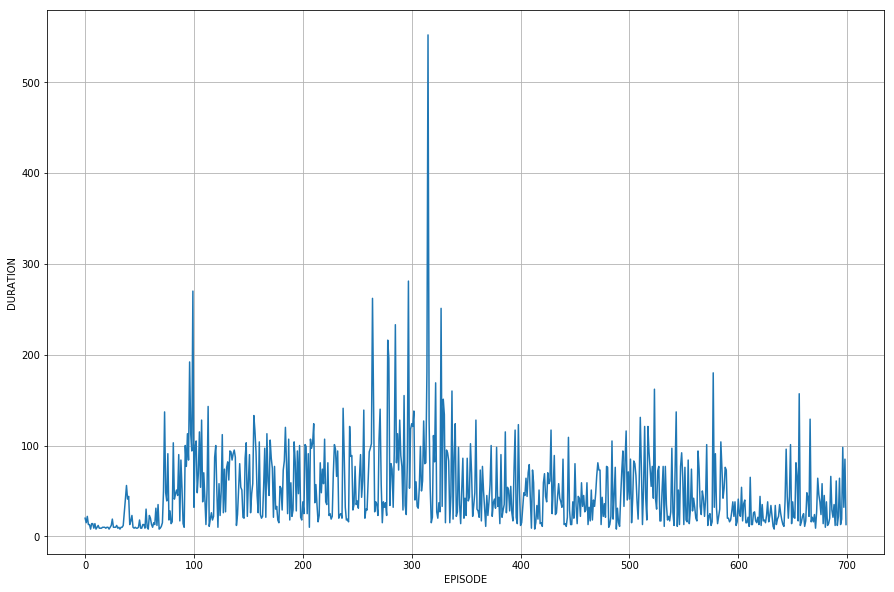

In [14]:
plot_durations()

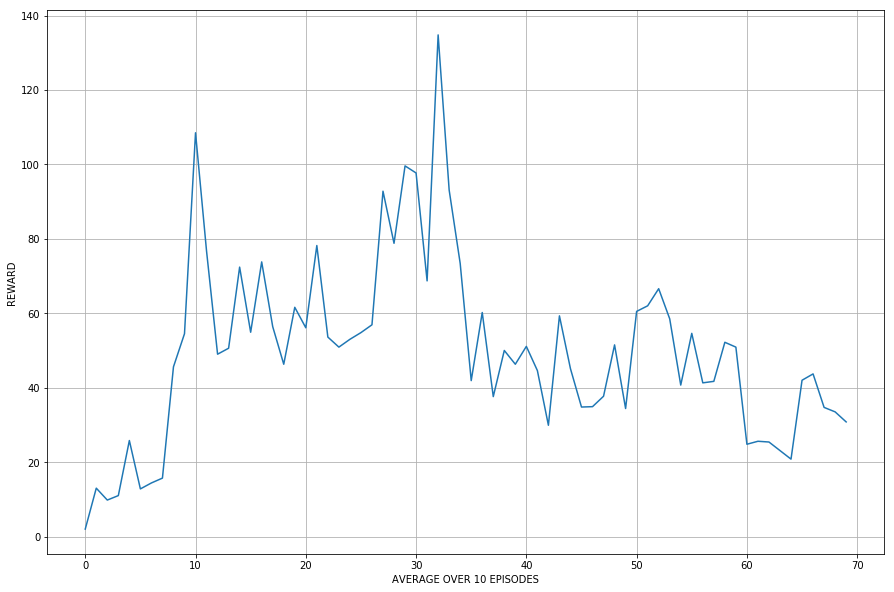

In [15]:
def plot_rewards():
    plt.figure(figsize=(15,10))
    plt.xlabel('AVERAGE OVER 10 EPISODES')
    plt.ylabel('REWARD')
    plt.plot(REWARDS)
    plt.grid()
    plt.show()
plot_rewards()

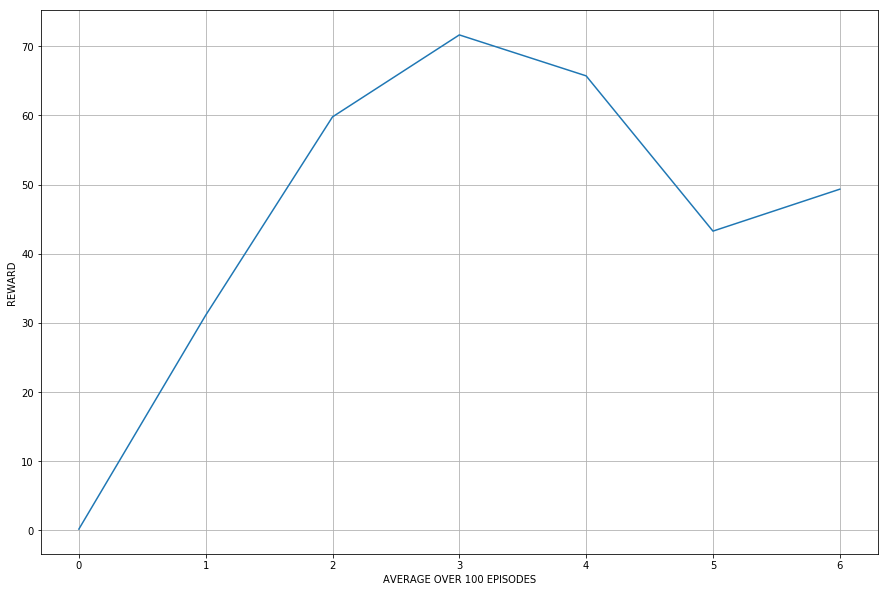

In [16]:
def plot_rewards():
    plt.figure(figsize=(15,10))
    plt.xlabel('AVERAGE OVER 100 EPISODES')
    plt.ylabel('REWARD')
    plt.plot(AVG_OVER_100)
    plt.grid()
    plt.show()
plot_rewards()

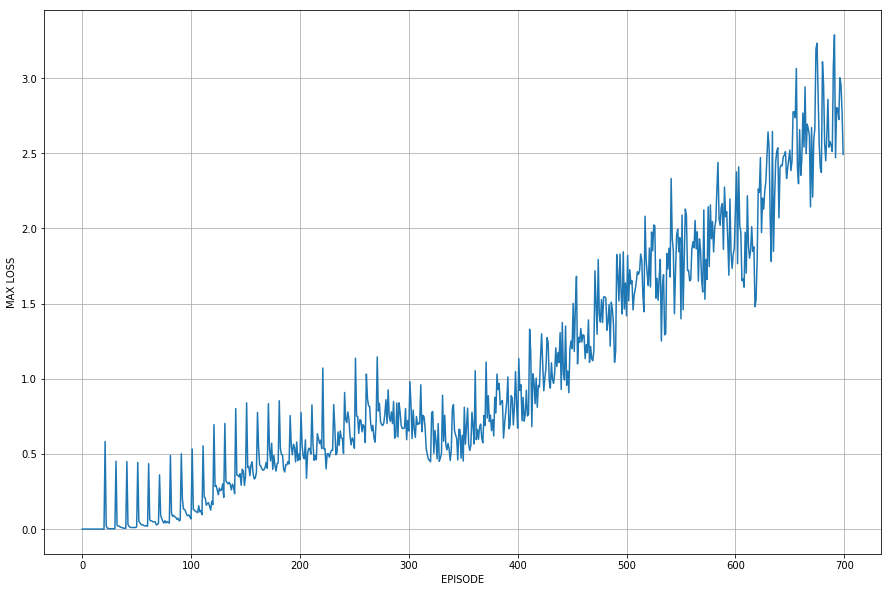

In [17]:
def plot_loss():
    plt.figure(figsize=(15,10))
    plt.xlabel('EPISODE')
    plt.ylabel('MAX LOSS')
    plt.plot(MAX_LOSS)
    plt.grid()
    plt.show()
plot_loss()